In [66]:
from database.data_importer import DataManagement
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import seaborn as sn
import altair as alt
from utils.data_preprocessor import DataPreprocessor

In [270]:
dm = DataManagement()
df = dm.db_query('select * from working_data')
df.head()
df_raw = df.query('type == "measurement"') 
df_raw = df_raw.astype({'value': float, 'batch':int})
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
dp = DataPreprocessor(df_raw[['batch', 'name', 'instance', 'log_order', 'timestamp', 'value']])
data = dp.get_processed_data()
df = data

/Users/amandahirschl/GIT Repos/bi2-team6-ws2020-21/Assignment 1/utils/data_preprocessor.py:76: UserWarning: The following series got reversed, as I assumed it was reversed perhaps: []
  warnings.warn(f"The following series got reversed, as I assumed it was reversed perhaps: {str(names)}")


In [387]:
data.query('batch=="7"').groupby('name').first()

timestamp  batch                              instance  log_order  \
name                                                                     
128     0 days    7.0  31aaa99c-930c-47b4-823b-b6364fe1c6ec        1.0   
157     0 days    7.0  ef70f227-5e6e-487d-bd12-acf0a36fd2da        1.0   
191     0 days    7.0  99ed5e9d-e654-44cb-a0a4-36235cb69e3e        1.0   
225     0 days    7.0  026879a0-34a1-4429-81e9-38864d6d2d87        1.0   
254     0 days    7.0  26c83dc1-c49e-4822-bd21-1ca7302ab3ae        1.0   
286     0 days    7.0  ae034340-df2d-4b21-9e7f-909b8759d4c7        1.0   
307     0 days    7.0  9b4a5166-f984-4e98-a0d6-1bd70878b975        1.0   
348     0 days    7.0  b0ba35b0-14fe-4080-97d3-b8b6160c2b61        1.0   
35      0 days    7.0  694eba1e-d9ae-4b85-b38d-f5d6b506c854        1.0   
369     0 days    7.0  1c30fc46-76bd-4eb8-a751-664c3857c9d6        1.0   
65      0 days    7.0  0adb8008-3f34-4d6f-83a4-358e4f02d182        1.0   
95      0 days    7.0  09f14722-5c65-4b42-b1a5-33c5f5afd92b        1.0   

          value  
name             
128   21.760000  
157   22.075000  
191   17.060000  
225   22.090000  
254   22.080000  
286   22.090000  
307   22.090000  
348   21.355000  
35    19.218571  
369   21.384000  
65    10.041765  
95    22.090000

536 2463 963.5
1499.0 2480.0 18.000000653887444 22.0 963.5 1.555786196159834


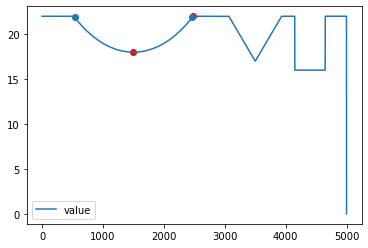

In [798]:
ref_value = 21.9
rook = pd.read_csv("model.csv", header=None).rename(columns={0: 'value'})

# Getting min and max points
v_min = rook.reset_index().query("index>300 and index <2500")[['value']].min()
v_max = rook.reset_index().query("index>300 and index <2500")[['value']].max()

look = rook.reset_index()
look = look.query("index>600 and index <2500")
i_min = look.loc[look['value'].idxmin()]['index']
i_max = look.loc[look['value'].idxmax()]['index']

rook.plot()
plt.scatter([i_min, i_max], [v_min, v_max], color='red')

rook['rounded'] = round(rook['value'], 1)
ref_rook1 = int(rook.reset_index().query('rounded == @ref_value and index<1499')[['index']].max())
ref_rook2 = int(rook.reset_index().query('rounded == @ref_value and index>1499')[['index']].min())

ref_rook = float((abs(ref_rook1-i_min) + abs(ref_rook2-i_min))/2)
print(ref_rook1, ref_rook2, ref_rook)

i_points = [i_min, i_max]
rook_vscale = i_min/float(ref_rook)
print(i_min, i_max, float(v_min), float(v_max), ref_rook, rook_vscale)
rook = rook.reset_index()
dist = ref_rook2 - ref_rook1
dist
plt.scatter([ref_rook1, ref_rook2], [ref_value,ref_value])


nan 2198.881533101045 nan
1446 nan
           index   value  new_index
101   527.522648  21.905        NaN
102   532.745645  21.885        NaN
103   537.968641  21.860        NaN
104   543.191638  21.835        NaN
105   548.414634  21.810        NaN
..           ...     ...        ...
495  2585.383275  21.950        NaN
496  2590.606272  21.975        NaN
497  2595.829268  21.990        NaN
498  2601.052265  22.005        NaN
499  2606.275261  22.020        NaN

[399 rows x 3 columns]
287.0 4591.01393728223 nan


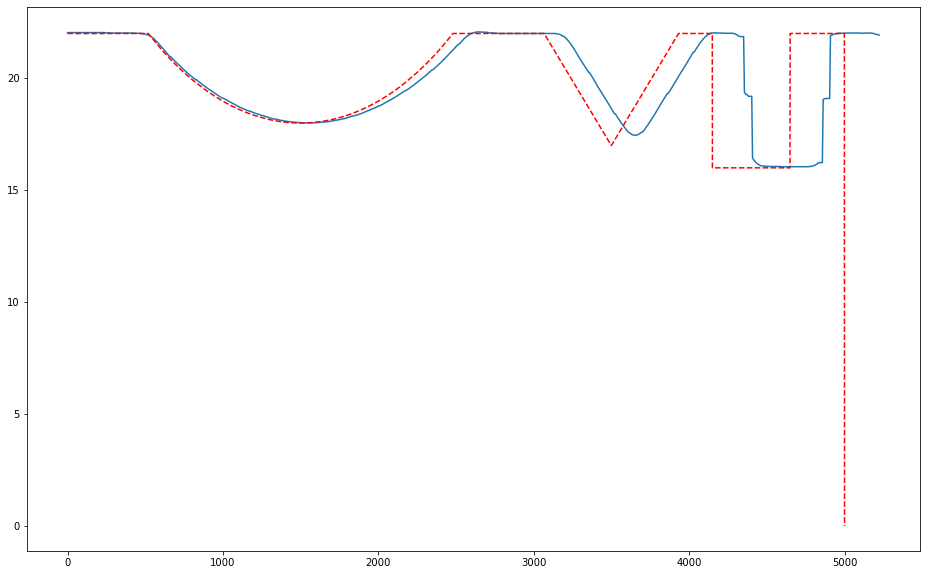

In [629]:
import math
names = df.query('name=="1446"').groupby('name', as_index=False).first()[['name']].to_numpy().flatten()
scale = {}

f, ax= plt.subplots(1, 1, sharey=True, figsize=(16,10))
for name in names:
    sample = df.query("name == @name").reset_index()[['value']].reset_index()
    look = sample.query("index>50 and index <550")
    i_min1 = look.loc[look['value'].idxmin()]['index']
    align = (i_points[0]/i_min1)
    sample['index'] = (sample['index']*align)
    i_min = sample.loc[sample['value'].idxmin()]['index']
    #print("a", i_min1, i_min)
    
    #scale horizontally
    look = sample.query("index>80*@align and index <550*@align")
    look['rounded'] = round(sample['value'], 2)
    ref_sample1 = float(look.query('rounded == @ref_value and index<@i_min')[['index']].max())
    ref_sample2 = float(look.query('rounded == @ref_value and index>@i_min')[['index']].min())
    ref_sample = float(( abs(ref_sample1 - i_min) + abs(ref_sample2 - i_min)) / 2)
    
    v_scale = (i_min-float(ref_sample))#/(i_min)#-float(ref_sample))
    print(ref_sample,ref_sample1, ref_sample2)
    v_scale_factor = round( ref_rook/ref_sample, 2)#(rook_vscale-ref_sample)/ rook_vscale
    #print("b", i_min, ref_sample1, ref_sample2, ref_sample)
    print(name,  v_scale_factor)
   
    plt.plot(sample['index'], sample['value'], label = 'v_original')
    
    sample['new_index'] =  (sample['index']* v_scale_factor)
    look = sample.query("index>100*@align and index <500*@align")
    print(look)
    i_min2 = sample.loc[look['value'].idxmin()]['new_index']
    print(i_min1, i_min, i_min2)
    align =  (i_points[0]-i_min2)/2
    
    #plt.plot(sample['new_index'], sample['value'], label='v_scaled')
    sample['new_index2'] = (sample['new_index']+(align))
    plt.plot(sample['new_index2'], sample['value'], label='v_scaled2', color='#a6b1ed')
    

plt.plot(rook['index'], rook['value'], label='ref', color='red', linestyle='dashed')
#plt.legend()

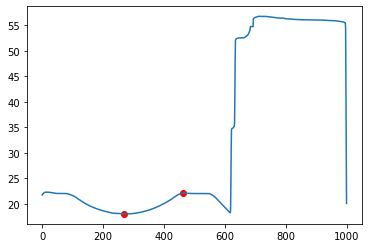

In [345]:

sample = df.query("name == '128'").reset_index()[['value']].reset_index()
v_min = sample.query("index>200 and index <550")[['value']].min()
v_max = sample.query("index>200 and index <550")[['value']].max()

look = sample.reset_index()
look = look.query("index>200 and index <550")
i_min = look.loc[look['value'].idxmin()]['index']
i_max = look.loc[look['value'].idxmax()]['index']

sample['value'].plot()
plt.scatter([i_min, i_max], [v_min, v_max], color='red')
#plt.plot(rook)

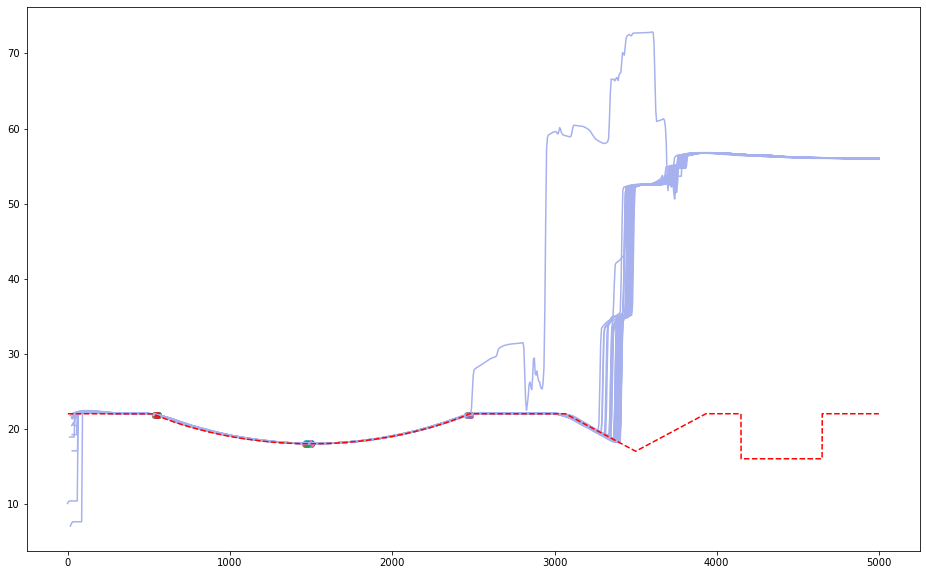

In [813]:
import math
names = df.query('batch!="11" and batch!="10"').groupby('name', as_index=False).first()[['name']].to_numpy().flatten()
#names = df.groupby('name', as_index=False).first()[['name']].to_numpy().flatten()
scale = {}
df_save = pd.DataFrame()

f, ax= plt.subplots(1, 1, sharey=True, figsize=(16,10))
for name in names:
    sample = df.query("name == @name").reset_index()[['value']].reset_index()
    look = sample.query("index>50 and index <550")
    i_min = look.loc[look['value'].idxmin()]['index']
       
    #scale horizontally
    look['rounded'] = round(sample['value'],1)
    ref_sample1 = float(look.query('rounded == @ref_value and index<@i_min')[['index']].max())
    ref_sample2 = float(look.query('rounded == @ref_value and index>@i_min')[['index']].min())
    ref_sample = float(( abs(ref_sample1 - i_min) + abs(ref_sample2 - i_min)) / 2)
    
    v_scale_factor = float(ref_rook/ref_sample)
    #print(name,  v_scale_factor)   
    
    #plt.plot(sample['index'], sample['value'], label = 'v_original')
    sample['new_index'] =  (sample['index']* v_scale_factor)
    
    look = sample.query("new_index>50*@v_scale_factor and new_index <550*@v_scale_factor")
    #i_min2 = look.loc[look['value'].idxmin()]['new_index']
    #print(i_min, i_min2)
    i_min2 = i_min * v_scale_factor
    #(i_points[0]-int(i_min2))+
    align = (((i_points[0]-(i_min2))+ (ref_rook1-ref_sample1*v_scale_factor) + (ref_rook2-ref_sample2*v_scale_factor))/3)
    #align = (((ref_rook1-ref_sample1*v_scale_factor) + (ref_rook2-ref_sample2*v_scale_factor))/2)#/2
    
    #plt.plot(sample['new_index'], sample['value'], label='v_scaled')
    sample['new_index2'] = (sample['new_index']+(align))
    #plt.plot(sample['new_index'], sample['value'], label='v_scaled')#, color='#a6b1ed')
    sample = sample.query("new_index2<5001")
    plt.plot(sample['new_index2'], sample['value'], label='v_aligned', color='#a6b1ed')
    
    #"""
    plt_ref1 = sample.query('index==@ref_sample1')
    plt_ref2 = sample.query('index==@ref_sample2') 
    plt_min = sample.query('new_index==@i_min2')
    plt.scatter(plt_min[['new_index2']], plt_min[['value']])
    plt.scatter(plt_ref1['new_index2'], plt_ref1['value'])
    plt.scatter(plt_ref2['new_index2'], plt_ref2['value'])
    #"""
    sample['name'] = name
    sample = sample.rename(columns={'new_index2': 'position'})
    df_save = df_save.append(sample[['name', 'position', 'value']])
    #print(ref_sample2*v_scale_factor - ref_sample1*v_scale_factor)
    #print(sample.query('index==@ref_sample2'))
    
rook2 = rook.drop(rook.tail(1).index) 
plt.plot(rook2['index'], rook2['value'], label='ref', color='red', linestyle='dashed')
#plt.legend()
len(df_save)
df_save
df_save.to_csv('batches_789_aligned.csv')

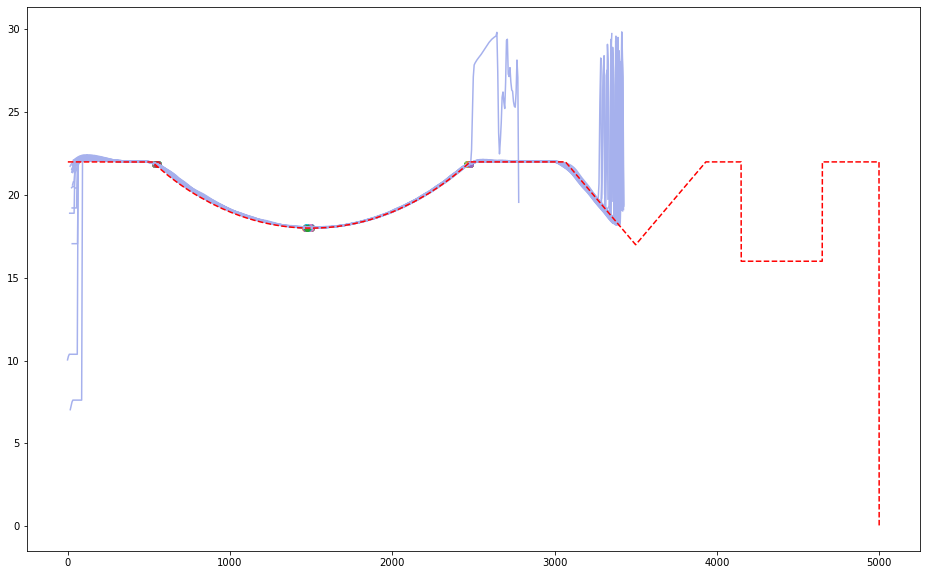

In [799]:
import math
names = df.query('batch!="11" and batch!="10"').groupby('name', as_index=False).first()[['name']].to_numpy().flatten()
#names = df.groupby('name', as_index=False).first()[['name']].to_numpy().flatten()
scale = {}

f, ax= plt.subplots(1, 1, sharey=True, figsize=(16,10))
for name in names:
    sample = df.query("name == @name and value<30").reset_index()[['value']].reset_index()
    look = sample.query("index>50 and index <550")
    i_min = look.loc[look['value'].idxmin()]['index']
       
    #scale horizontally
    look['rounded'] = round(sample['value'],1)
    ref_sample1 = float(look.query('rounded == @ref_value and index<@i_min')[['index']].max())
    ref_sample2 = float(look.query('rounded == @ref_value and index>@i_min')[['index']].min())
    ref_sample = float(( abs(ref_sample1 - i_min) + abs(ref_sample2 - i_min)) / 2)
    
    v_scale_factor = float(ref_rook/ref_sample)
    #print(name,  v_scale_factor)   
    
    #plt.plot(sample['index'], sample['value'], label = 'v_original')
    sample['new_index'] =  (sample['index']* v_scale_factor)
    
    look = sample.query("new_index>50*@v_scale_factor and new_index <550*@v_scale_factor")
    #i_min2 = look.loc[look['value'].idxmin()]['new_index']
    #print(i_min, i_min2)
    i_min2 = i_min * v_scale_factor
    #(i_points[0]-int(i_min2))+
    align = (((i_points[0]-(i_min2))+ (ref_rook1-ref_sample1*v_scale_factor) + (ref_rook2-ref_sample2*v_scale_factor))/3)
    #align = (((ref_rook1-ref_sample1*v_scale_factor) + (ref_rook2-ref_sample2*v_scale_factor))/2)#/2
    
    #plt.plot(sample['new_index'], sample['value'], label='v_scaled')
    sample['new_index2'] = (sample['new_index']+(align))
    #plt.plot(sample['new_index'], sample['value'], label='v_scaled')#, color='#a6b1ed')
    plt.plot(sample['new_index2'], sample['value'], label='v_aligned', color='#a6b1ed')
    
    #"""
    plt_ref1 = sample.query('index==@ref_sample1')
    plt_ref2 = sample.query('index==@ref_sample2') 
    plt_min = sample.query('new_index==@i_min2')
    plt.scatter(plt_min[['new_index2']], plt_min[['value']])
    plt.scatter(plt_ref1['new_index2'], plt_ref1['value'])
    plt.scatter(plt_ref2['new_index2'], plt_ref2['value'])
    #"""
    
    #print(ref_sample2*v_scale_factor - ref_sample1*v_scale_factor)
    #print(sample.query('index==@ref_sample2'))
    
rook2 = rook#rook.drop(rook.tail(1).index) 
plt.plot(rook2['index'], rook2['value'], label='ref', color='red', linestyle='dashed')
#plt.legend()

In [277]:
scale = (i_points[0]/i_min)
scale

5.551851851851852

In [347]:
sample['rounded'] = round(sample['value'], 1)
ref_sample = sample.query('rounded == 19.0 and index<270')[['index']].max()
ref_sample2 = sample.query('rounded == 19.0 and index>270')[['index']].min()
ref_sample, ref_sample2

(index    183
 dtype: int64,
 index    360
 dtype: int64)

In [359]:
sample.query('rounded == 20.0')[['index']]

index
139    139
140    140
141    141
395    395
396    396
397    397
588    588

In [285]:
rook.query('value > 18.99 and value < 19.011' )

value
991   19.010967
992   19.006991
993   19.002582
994   18.998622
995   18.994670
996   18.990726
2003  18.991164
2004  18.995109
2005  18.999062
2006  19.003022
2007  19.007432
3326  19.002075
3327  18.990500
3672  18.990900
3673  19.002475

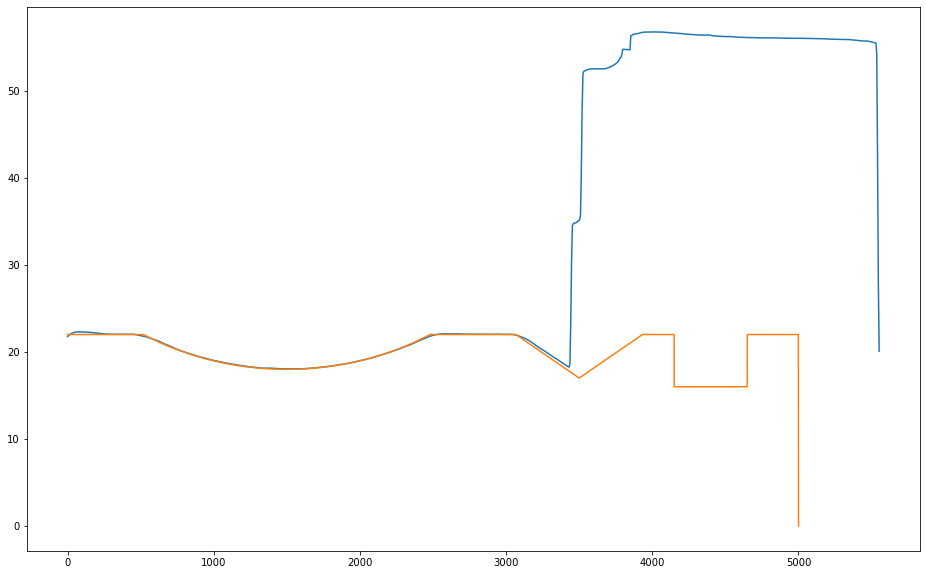

In [278]:
f, ax= plt.subplots(1, 1, sharey=True, figsize=(16,10))
sample = sample['value'].reset_index()
sample['index'] = (sample['index']*scale)
plt.plot(sample['index'], sample['value'])
plt.plot(rook)

In [ ]:
rook